# NCAR JupyterHub Large Data Example Notebook

*Note: If you do not have access to the NCAR machine, please look at the AWS-LENS example notebook instead.*

This notebook demonstrates how to compare large datasets on glade with ldcpy.  In particular, we will look at data from CESM-LENS1 project (http://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html). In doing so, we will start a DASK client from Jupyter.  This notebook is meant to be run on NCAR's JupyterHub (https://jupyterhub.ucar.edu). We will use a subset of the CESM-LENS1 data on glade is located in /glade/p/cisl/asap/ldcpy_sample_data. 

We assume that you have a copy of the ldcpy code on NCAR's glade filesystem, obtained via:<br>
    `git clone https://github.com/NCAR/ldcpy.git`

When you launch your NCAR JupyterHub session, you will need to indicate a machine (Casper) and then you will need your charge account.  You can then launch the session and navigate to this notebook.  

Here's good resource for using NCAR's JupyterHub:<br>
https://ncar-hackathons.github.io/jupyterlab-tutorial/jhub.html)


**You need to run your notebook with the "cmip6-201910" kernel (choose from the dropdown in the upper left.)**


Note that the compressed data that we are using was generated for this paper:

Allison H. Baker, Dorit M. Hammerling, Sheri A. Mickelson, Haiying Xu, Martin B. Stolpe, Phillipe Naveau, Ben Sanderson, Imme Ebert-Uphoff, Savini Samarasinghe, Francesco De Simone, Francesco Carbone, Christian N. Gencarelli, John M. Dennis, Jennifer E. Kay, and Peter Lindstrom, “Evaluating Lossy Data Compression on Climate Simulation Data within a Large Ensemble.”  Geoscientific Model Development, 9, pp. 4381-4403, 2016 
(https://gmd.copernicus.org/articles/9/4381/2016/)




## Setup
Let's set up our environment.  First, make sure that you are using the cmip6-2019.10 kernel on Casper.  Then you will need to modify the path below to indicate where you have cloned ldcpy. (_Note: soon we will install ldcpy on Casper in the cmpi6-2019.10 kernel_ .)

If you want to use the dask dashboard, then the dask.config link must be set below (modify for your path in your browser).  

In [1]:
#Make sure you are using the cmpi6-2019.10 kernel 

#Add ldcpy root to system path (MODIFY FOR YOUR LDCPY CODE LOCATION)
import sys
sys.path.insert(0,'/glade/u/home/abaker/repos/ldcpy')
import ldcpy

#Display output of plots directly in Notebook
%matplotlib inline
#Automatically reload module if it is editted
%reload_ext autoreload
%autoreload 2

#silence warnings
import warnings
warnings.filterwarnings("ignore")

#if you want to use the DASK daskboard, then modify the below and run
import dask
dask.config.set({'distributed.dashboard.link' : 'https://jupyterhub.ucar.edu/dav/user/abaker/proxy/{port}/status'})


### Connect to DASK distributed cluster (Casper uses slurm):

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(memory="40GB", cores=4, processes=1, walltime="00:45:00", project="NIOW0001")
#scale as needed
cluster.adapt(minimum_jobs=1, maximum_jobs=35)
cluster

In [3]:
# Look at the job script (optional)
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A NIOW0001
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=38G
#SBATCH -t 00:45:00
#SBATCH -C skylake

/ncar/usr/jupyterhub/envs/cmip6-201910/bin/python -m distributed.cli.dask_worker tcp://10.12.205.11:40119 --nthreads 4 --memory-limit 40.00GB --name name --nanny --death-timeout 60 --interface ib0



In [4]:
# Connect client to the remote dask workers
client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.11:40119 Dashboard: https://jupyterhub.ucar.edu/dav/user/abaker/proxy/40385/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


_Note: click on the daskboard link above to see you DASK tasks_

## The sample data on the glade filesystem

In /glade/p/cisl/asap/ldcpy_sample_data on glade, we have TS (surface temperature), PRECT (precipiation rate), and PS (surface pressure) data from CESM-LENS1. These all all 2D variables.  TS and PRECT have daily output, and PS has monthly output.  We have the compressed and original versions of all these variables that we would like to compare with ldcpy.

First we list what is in this directory (two subdirectories):

In [5]:
#list directory contents
import os
os.listdir('/glade/p/cisl/asap/ldcpy_sample_data')

['lossy', 'orig']

Now we look at the contents of each subdirectory.  We have 6 files in each, consisting of 2 different timeseries files for each variable (1920-2005 and 2006-2080).

In [6]:
#list lossy directory contents (files that have been lossy compressed and reconstructed)
lossy_files = os.listdir('/glade/p/cisl/asap/ldcpy_sample_data/lossy')
lossy_files

['c.TS.daily.19200101-20051231.nc',
 'c.PRECT.daily.20060101-20801231.nc',
 'c.PS.monthly.200601-208012.nc',
 'c.PRECT.daily.19200101-20051231.nc',
 'c.TS.daily.20060101-20801231.nc',
 'c.PS.monthly.192001-200512.nc']

In [7]:
#list orig (i.e., uncompressed) directory contents
orig_files = os.listdir('/glade/p/cisl/asap/ldcpy_sample_data/orig')
orig_files

['PRECT.daily.20060101-20801231.nc',
 'PS.monthly.192001-200512.nc',
 'PRECT.daily.19200101-20051231.nc',
 'TS.daily.20060101-20801231.nc',
 'PS.monthly.200601-208012.nc',
 'TS.daily.19200101-20051231.nc']

We can look at how big these files are...

In [8]:
print ('Original files')
for f in orig_files:
    print(f ," ", os.stat('/glade/p/cisl/asap/ldcpy_sample_data/orig/' + f).st_size/1e9, 'GB')

Original files
PRECT.daily.20060101-20801231.nc   4.999422499 GB
PS.monthly.192001-200512.nc   0.129124682 GB
PRECT.daily.19200101-20051231.nc   5.73270249 GB
TS.daily.20060101-20801231.nc   3.50467262 GB
PS.monthly.200601-208012.nc   0.112432632 GB
TS.daily.19200101-20051231.nc   4.042198426 GB


### Open datasets

First, let's look at the original and reconstructed files for the monthly surface Pressure (PS) data for 1920-2006. We begin by using ldcpy.open_dataset() to open the files of interest into our dataset collection.  Note that for this dataset, we use "persist.()" after open_datasets() to speed up subsequent calculations. Usually we want chunks to be 100-150MB, but this is machine and app dependent.

In [11]:
#load the first 86 years of montly surface pressure into a collection

col_PS = ldcpy.open_datasets(["PS"], ['/glade/p/cisl/asap/ldcpy_sample_data/orig/PS.monthly.192001-200512.nc', 
                            '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.PS.monthly.192001-200512.nc'],
                           ['orig', 'lossy'],chunks={'time': 500}).persist()
col_PS


dataset size in GB 0.46



<xarray.Dataset>
Dimensions:     (collection: 2, lat: 192, lon: 288, time: 1032)
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time        (time) object 1920-02-01 00:00:00 ... 2006-01-01 00:00:00
  * collection  (collection) <U5 'orig' 'lossy'
Data variables:
    PS          (collection, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys0219
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

## Data comparison

Now we use the ldcpy package features to compare the data.

### Surface Pressure 
Let's look at the comparison statistics at the first timeslice for PS.

In [12]:
ldcpy.compare_stats(col_PS, 'PS', 'orig', 'lossy', time=0)

Comparing orig data (set1) to lossy data (set2)
 
mean set1: 96750
mean set2: 96730
mean diff: 15.81
 
variance set1: 8.425e+07
variance set2: 8.425e+07
 
standard deviation set1: 9179
standard deviation set2: 9179
 
max value set1: 103000
max value set2: 103000
min value set1: 51970
min value set2: 51950
 
max abs diff: 31.99
min abs diff: 0
mean abs diff: 15.81
mean squared diff: 249.8
root mean squared diff: 18.3
normalized root mean squared diff: 0.0003587
normalized max pointwise error: 0.000627
pearson correlation coefficient: 1
ks p-value: 0.01454
spatial relative error(% > 0.0001): 69.08
ssim: 0.9978


Now we compare the mean PS values across time in the orig and lossy datasets.

 SSIM 1 & 2 =  0.99674



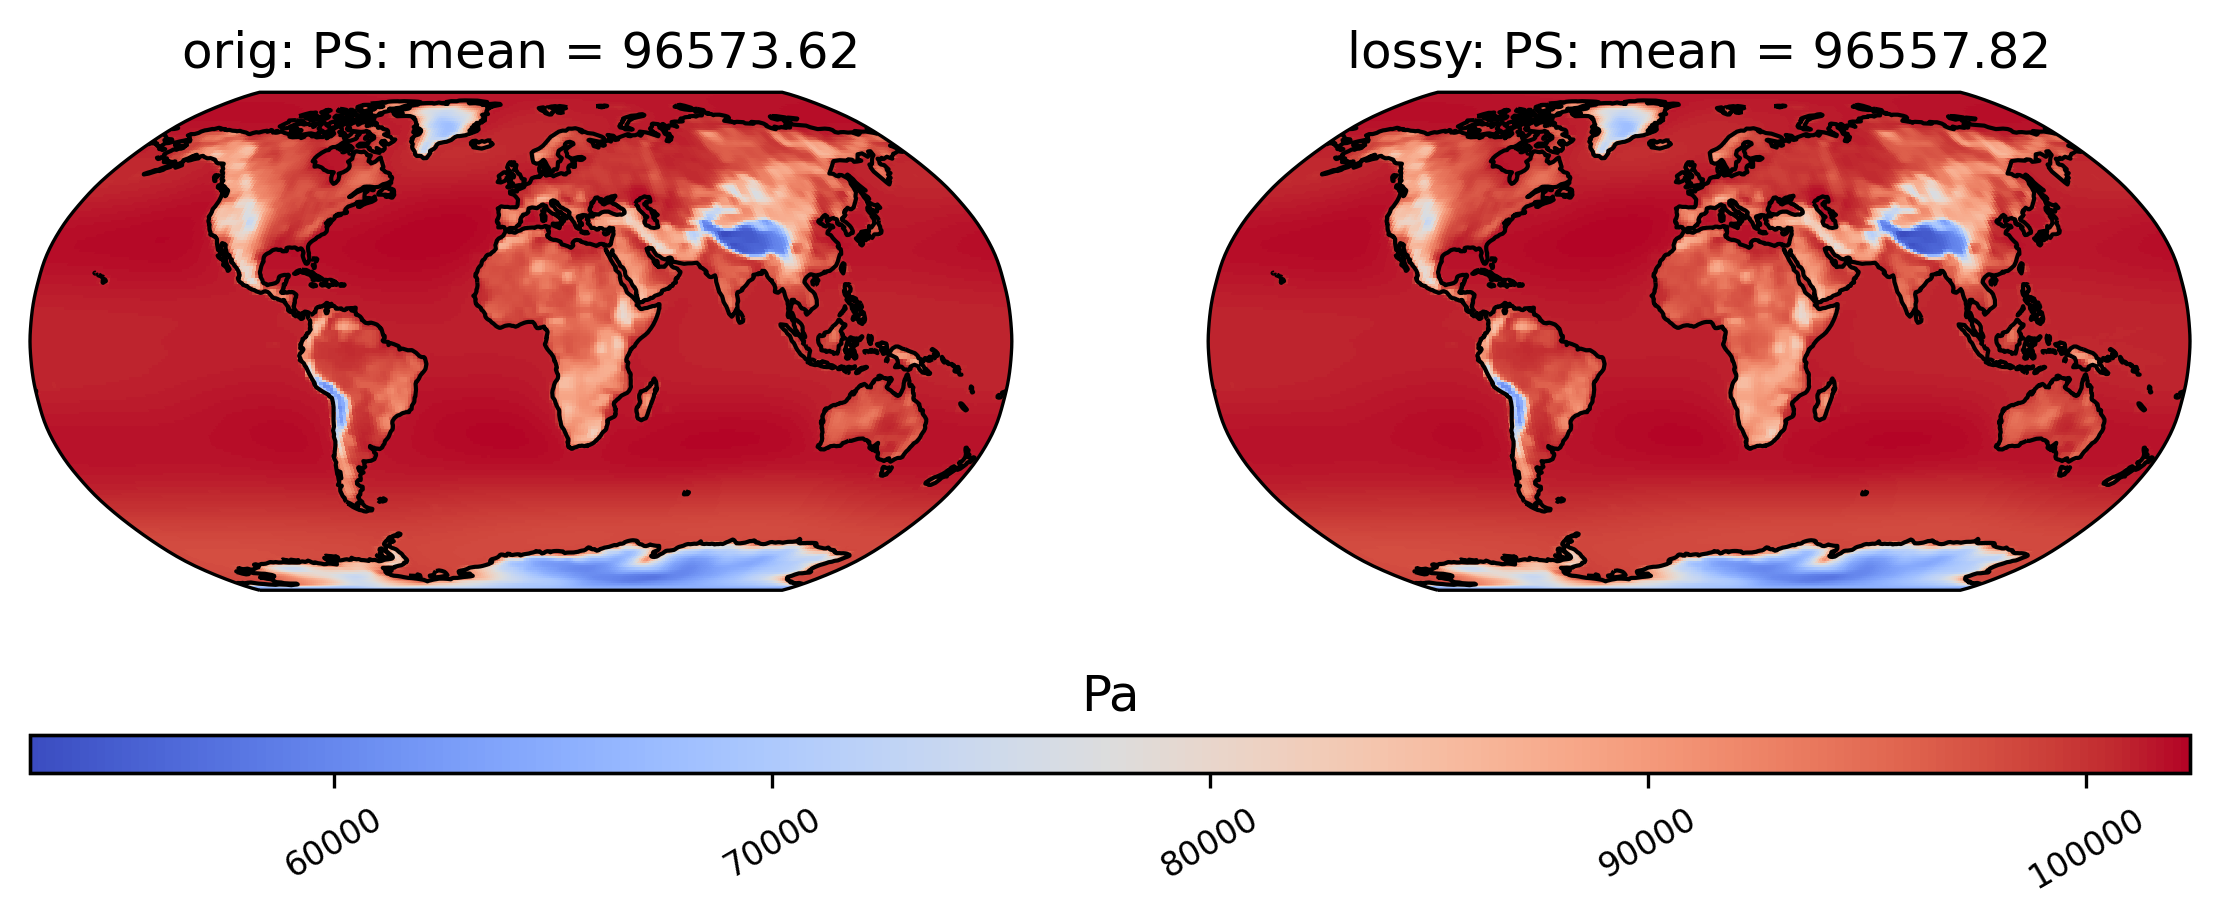

In [13]:
# comparison between mean PS values in col_PS orig and lossy datasets
ldcpy.plot(col_PS, "PS", sets=['orig', 'lossy'], metric='mean', calc_ssim = True)

Now we instead show the difference plot for the above plots.

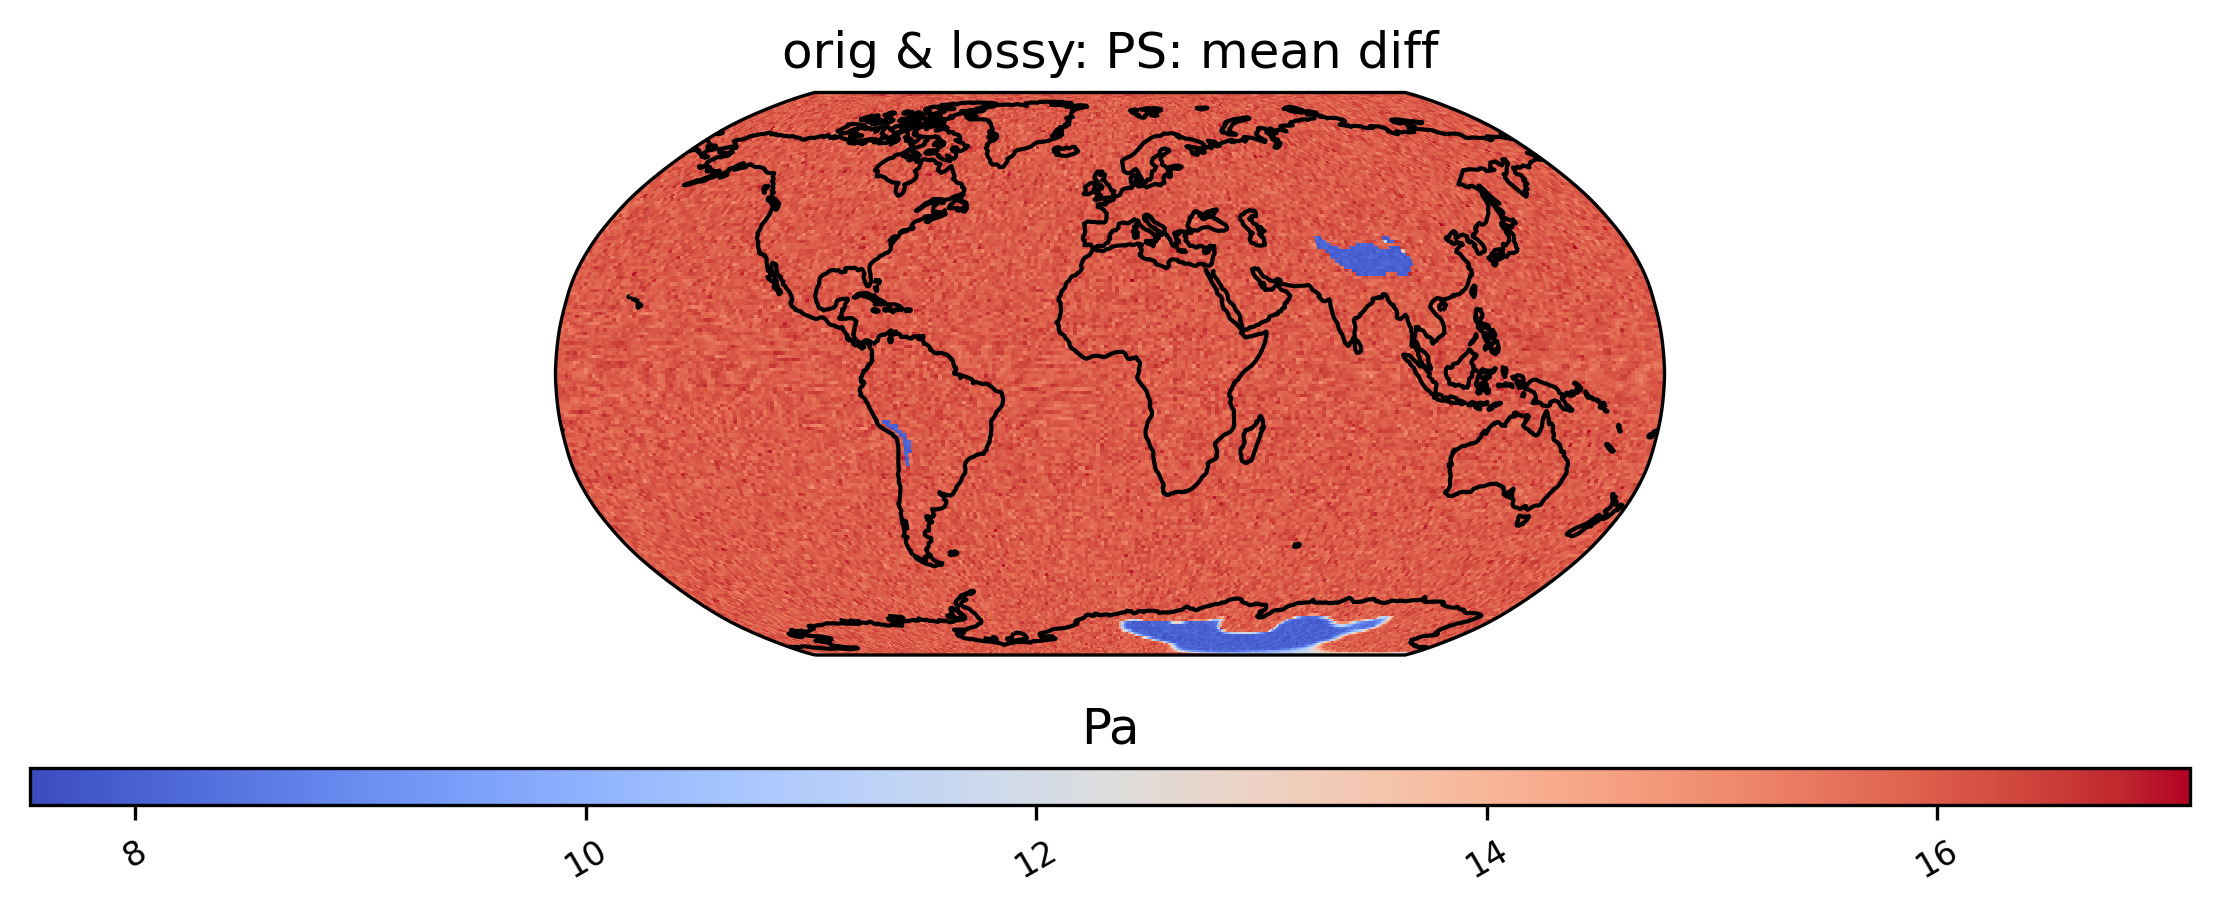

In [14]:
# diff between mean PS values in col_PS orig and lossy datasets
ldcpy.plot(col_PS, "PS", sets=['orig','lossy'], metric='mean', metric_type='diff')

We can also look at mean differences over time.  Here we are looking at the spatial averages and then grouping by day of the year. If doing a timeseries plot for this much data, using "group_by" is often a good idea.

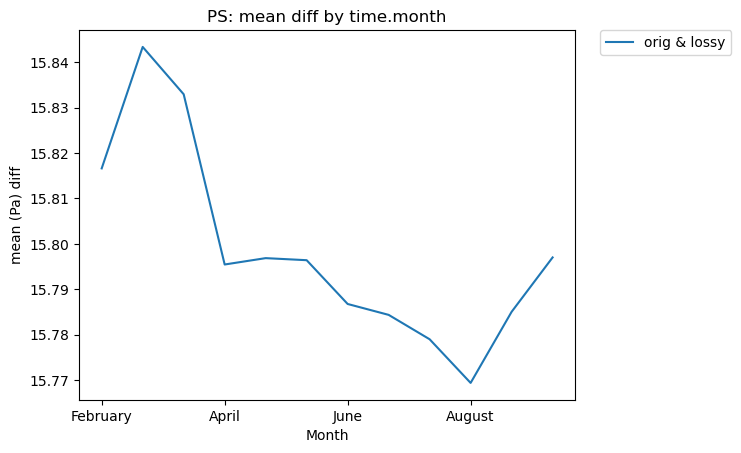

In [15]:
# Time-series plot of mean PS differences between col_PS orig and col_PS lossy datasets grouped by month of year
ldcpy.plot(col_PS, "PS", sets=['orig',"lossy"], metric='mean', plot_type="time_series", 
           group_by="time.month", metric_type="diff")

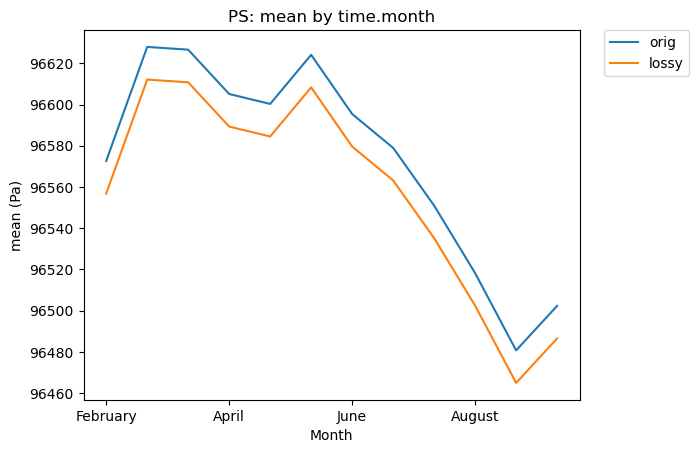

In [16]:
# Time-series plot of PS mean (grouped by month) in the original and lossy datasets
ldcpy.plot(col_PS, "PS", sets=['orig', 'lossy'], metric='mean', plot_type="time_series", group_by="time.month")

### Surface Temperature

Now let's open the daily surface temperature (TS) data for 1920-2005 into a collection. These are larger files than the monthly PS data.

In [17]:
#load the first 86 years of daily surface temperature (TS) data
col_TS = ldcpy.open_datasets(["TS"],
                            ['/glade/p/cisl/asap/ldcpy_sample_data/orig/TS.daily.19200101-20051231.nc', 
                                 '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.TS.daily.19200101-20051231.nc'],
                         ['orig', 'lossy'], chunks={'time': 500}).persist()
col_TS

dataset size in GB 13.89



,Array,Chunk
Bytes,13.89 GB,110.59 MB
Shape,"(2, 31390, 192, 288)","(1, 500, 192, 288)"
Count,126 Tasks,126 Chunks
Type,float32,numpy.ndarray


Look at the first time slice (time = 0) statistics:

In [18]:
ldcpy.compare_stats(col_TS, 'TS', 'orig', 'lossy', time=0)

Comparing orig data (set1) to lossy data (set2)
 
mean set1: 274.7
mean set2: 274.7
mean diff: 0.05491
 
variance set1: 534
variance set2: 533.4
 
standard deviation set1: 23.11
standard deviation set2: 23.1
 
max value set1: 315.6
max value set2: 315.5
min value set1: 216.7
min value set2: 216.7
 
max abs diff: 0.125
min abs diff: 0
mean abs diff: 0.05491
mean squared diff: 0.003015
root mean squared diff: 0.06527
normalized root mean squared diff: 0.0006603
normalized max pointwise error: 0.001264
pearson correlation coefficient: 1
ks p-value: 0.005516
spatial relative error(% > 0.0001): 73.29
ssim: 0.9983


Now we compare mean TS over time:

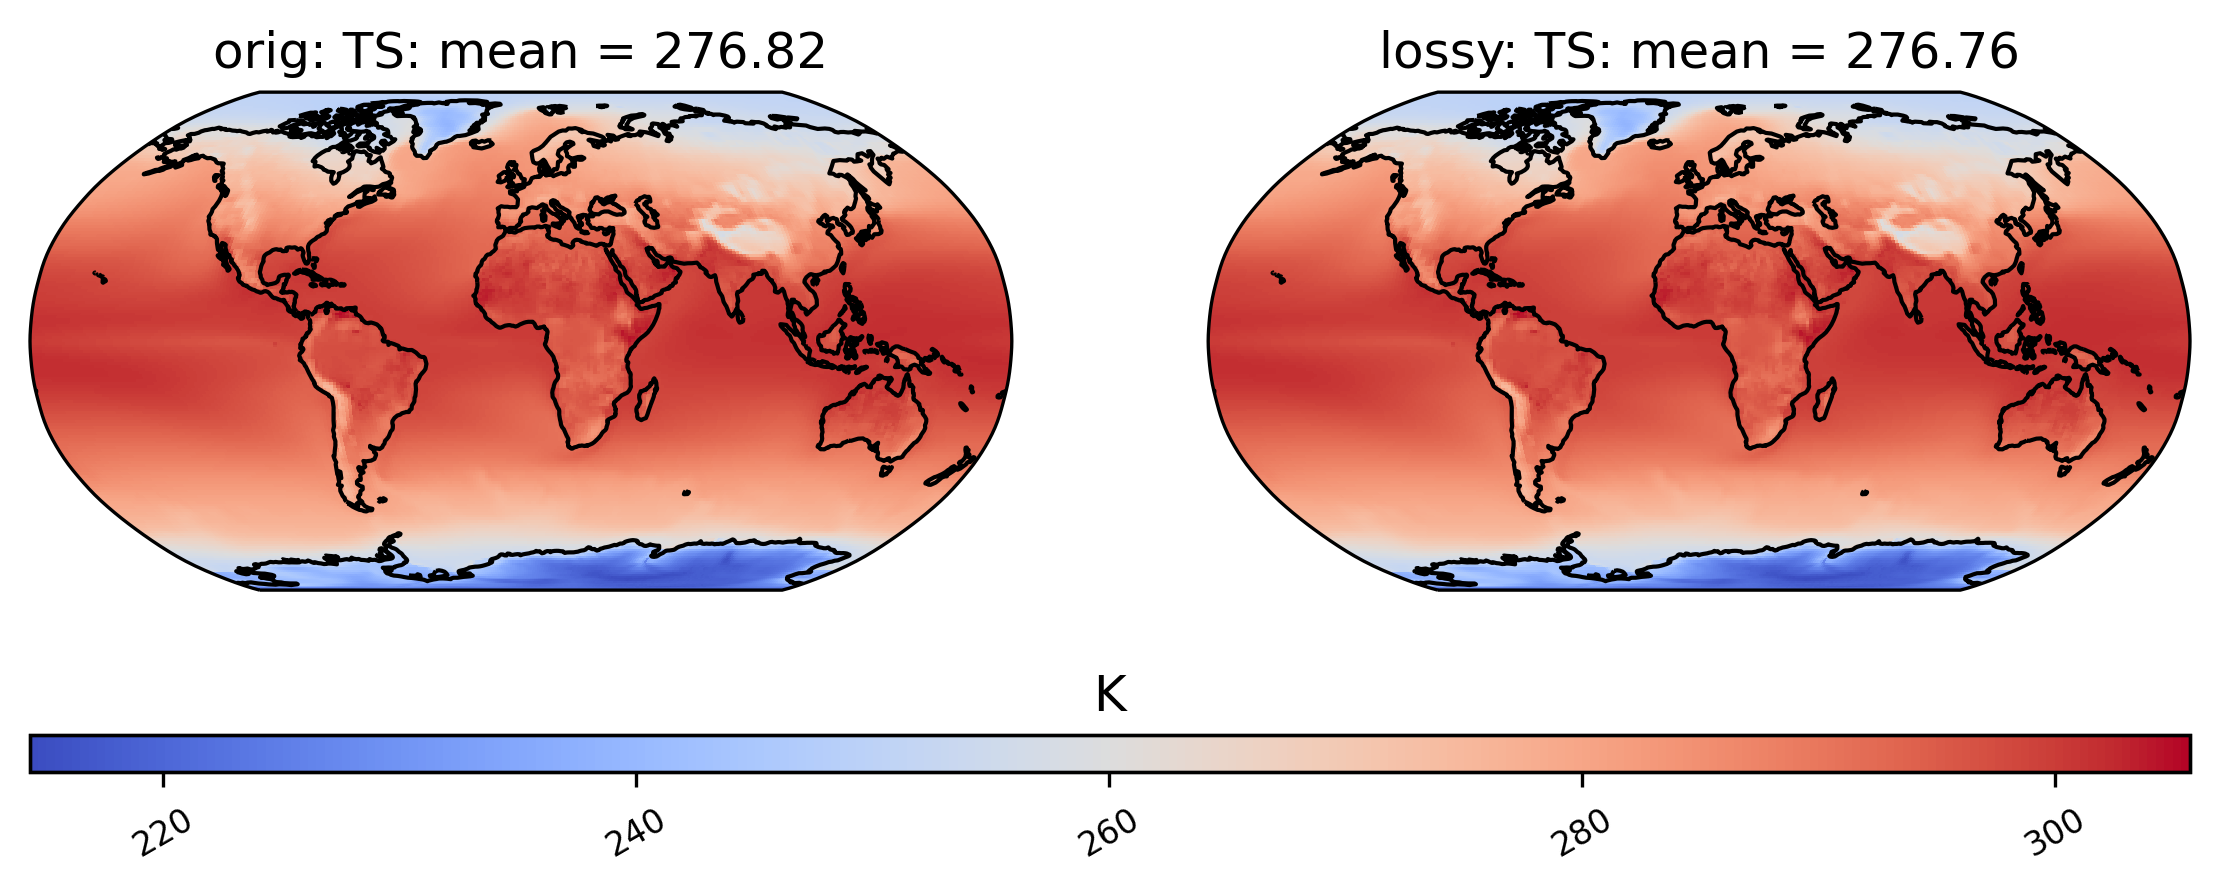

In [19]:
# comparison between mean TS values in col_TS orig and lossy datasets
ldcpy.plot(col_TS, "TS", sets=['orig', 'lossy'], metric='mean')

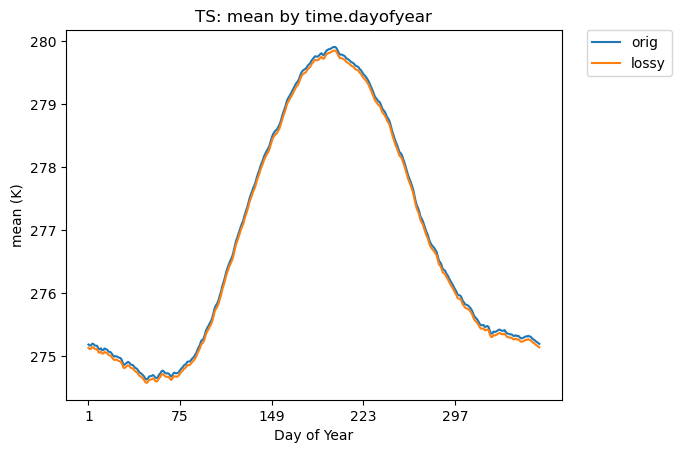

In [20]:
# Time-series plot of TS means (grouped by days) in the original and lossy datasets
ldcpy.plot(col_TS, "TS", sets=['orig', 'lossy'], metric='mean', plot_type="time_series", group_by="time.dayofyear")

Let's delete the PS and TS data to free up memory.

In [21]:
del col_PS
del col_TS

## Precipitation Rate
Now let's open the daily precipitation rate (PRECT) data for 2006-2080 into a collection. 

In [22]:
#load the last 75 years of PRECT data
col_PRECT = ldcpy.open_datasets(["PRECT"],
                            ['/glade/p/cisl/asap/ldcpy_sample_data/orig/PRECT.daily.20060101-20801231.nc', 
                                 '/glade/p/cisl/asap/ldcpy_sample_data/lossy/c.PRECT.daily.20060101-20801231.nc'],
                         ['orig', 'lossy'], chunks={'time': 500}).persist()
col_PRECT

dataset size in GB 12.11



,Array,Chunk
Bytes,12.11 GB,110.59 MB
Shape,"(2, 27375, 192, 288)","(1, 500, 192, 288)"
Count,110 Tasks,110 Chunks
Type,float32,numpy.ndarray


In [ ]:
# plot of lag-1 correlation of PRECT values in original dataset
ldcpy.plot(col_PRECT, "PRECT", sets=["orig"], metric="corr_lag1")


In [ ]:
# plot of lag-1 correlation of PRECT values in compressed dataset
ldcpy.plot(col_PRECT, "PRECT", sets=["lossy"], metric="corr_lag1")


Continue doing any comparisons that you like.  Be sure to close the cluster and client when finished.

In [ ]:
cluster.close()
client.close()